In [1]:
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow as tf
from scipy import stats
from scipy.signal import butter, filtfilt, savgol_filter
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

2024-07-14 03:08:57.499492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 03:08:57.499623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 03:08:57.744612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data

In [2]:
# Parameters
input_dir = '/kaggle/input/har-competition-onsite/HAR'
split_val = 0.2
frame_len = 100
hop_len = 50
epochs = 50
batch_size = 64

# Data Preparation
train_dir = input_dir + '/train'
# train_dir = '/kaggle/working/HAR'
test_dir = input_dir + '/test'
df_paths = glob(os.path.join(train_dir, '*', '*.csv'))

dataset_paths = {'train': [], 'val': []}
for activity_dir in glob(os.path.join(train_dir, '*')):
    paths = glob(os.path.join(activity_dir, '*.csv'))
#     dataset_paths['train'].extend(paths)
    train_paths, val_paths = train_test_split(paths, test_size=0.2, random_state=42)
    dataset_paths['train'].extend(train_paths)
    dataset_paths['val'].extend(val_paths)

In [3]:
def augment_data(data):
#     noise_factor = 0.05
    noise_factor = 0.1
    noisy_data = data + noise_factor * np.random.randn(*data.shape)
    return noisy_data

def frame(x, frame_len, hop_len):
    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    return np.stack([x[i*hop_len : i*hop_len + frame_len] for i in range(n_frames)])

def extract_features(df):
    # Time-domain features
    for col in ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']:
        df[f'{col}_mean'] = np.mean(df[col])
        df[f'{col}_std'] = np.std(df[col])
        df[f'{col}_max'] = np.max(df[col])
        df[f'{col}_min'] = np.min(df[col])
        df[f'{col}_median'] = np.median(df[col])
        df[f'{col}_skewness'] = stats.skew(df[col])
        df[f'{col}_kurtosis'] = stats.kurtosis(df[col])
        df[f'{col}_rms'] = np.sqrt(np.mean(df[col]**2))
        
    # Correlation features
    acc_corr = df[['Acc_X', 'Acc_Y', 'Acc_Z']].corr()
    gyr_corr = df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].corr()
    
    df['acc_corr_xy'] = acc_corr.loc['Acc_X', 'Acc_Y']
    df['acc_corr_xz'] = acc_corr.loc['Acc_X', 'Acc_Z']
    df['acc_corr_yz'] = acc_corr.loc['Acc_Y', 'Acc_Z']
    
    df['gyr_corr_xy'] = gyr_corr.loc['Gyr_X', 'Gyr_Y']
    df['gyr_corr_xz'] = gyr_corr.loc['Gyr_X', 'Gyr_Z']
    df['gyr_corr_yz'] = gyr_corr.loc['Gyr_Y', 'Gyr_Z']
    
    # Magnitude features
    acc_mag = np.sqrt(df['Acc_X']**2 + df['Acc_Y']**2 + df['Acc_Z']**2)
    gyr_mag = np.sqrt(df['Gyr_X']**2 + df['Gyr_Y']**2 + df['Gyr_Z']**2)
    
    df['acc_mag_mean'] = np.mean(acc_mag)
    df['acc_mag_std'] = np.std(acc_mag)
    df['gyr_mag_mean'] = np.mean(gyr_mag)
    df['gyr_mag_std'] = np.std(gyr_mag)
    
    # Frequency-domain features
    for col in ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']:
        fft_vals = np.abs(fft(df[col].values)) 
        df[f'{col}_fft_mean'] = np.mean(fft_vals)
        df[f'{col}_fft_max'] = np.max(fft_vals)
        df[f'{col}_fft_energy'] = np.sum(fft_vals**2) / len(fft_vals)
    
    return df

def add_savgol_filter(df):
    for col in df.columns:
        df[col + '_salgov2'] = savgol_filter(df[col], window_length=5, polyorder=2)
        df[col + '_salgov3'] = savgol_filter(df[col], window_length=5, polyorder=3)
    return df

def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def remove_outliers(series, threshold=3):
    mean = np.mean(series)
    std = np.std(series)
    return series[(series > mean - threshold * std) & (series < mean + threshold * std)]

def preprocess(df):
#     df = extract_features(df)
    # Apply the filter to the accelerometer data
    fs = 50  # Sampling frequency in Hz
    cutoff = 5  # Cutoff frequency in Hz
    for col in df.columns:
#         df[col] = low_pass_filter(df[col], cutoff, fs)
        df[col] = df[col].interpolate()

    df = add_savgol_filter(df)
#     df.drop(columns=['Acc_Y', 'Gyr_Y'], inplace=True)
    return df

# Load and frame data
def load_data(paths):
    X, y = [], []
    for path in paths:
        df = preprocess(pd.read_csv(path))
        df_values = df.values
        activity = path.split('/')[-2]
        frames = frame(df_values, frame_len, hop_len)
        X.append(frames)
        y.extend([activity] * frames.shape[0])
    X = np.concatenate(X, axis=0)
    return X, np.array(y)

In [4]:
X_train, y_train = load_data(dataset_paths['train'])

# Oversampling
samples, height, width = X_train.shape
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train.reshape(len(X_train), -1), y_train)

# Reshape X_resampled back to 3D array
X_train = X_train.reshape(len(X_train), height, width)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Data Augmentation
X_train_augmented = augment_data(X_train)

# Combine original and augmented data
X_train_combined = np.concatenate([X_train, X_train_augmented])
y_train_combined = np.concatenate([y_train, y_train])

# Encode labels
label_encoder = LabelEncoder()
y_train_combined = label_encoder.fit_transform(y_train_combined)

X_val, y_val = load_data(dataset_paths['val'])
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val = label_encoder.transform(y_val)

In [5]:
X_train_combined.shape

(28584, 100, 18)

# Model

In [ ]:
samples, height, width = X_train_combined.shape
X_train_2d = X_train_combined.reshape(samples, height * width)

cat = CatBoostClassifier(iterations=1000,
                         eval_metric='Accuracy', task_type="GPU", devices='0')

cat.fit(X_train_2d, y_train_combined, 
        eval_set=(X_val, y_val), 
        use_best_model=True)

samples, height, width = X_val.shape
X_val_2d = X_val.reshape(samples, height * width)

y_pred = cat.predict(X_val_2d)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

In [12]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(frame_len, X_train.shape[-1]), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    Bidirectional(LSTM(128, return_sequences=True)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(len(np.unique(y_train_combined)), activation='softmax')
])

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 98, 64)         │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 47, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 10, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,785 (3.25 MB)

 Trainable params: 850,889 (3.25 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Cross-validation
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train_combined):
    X_train_k, X_val_k = X_train_combined[train_index], X_train_combined[val_index]
    y_train_k, y_val_k = y_train_combined[train_index], y_train_combined[val_index]
    history = model.fit(X_train_k, y_train_k, epochs=epochs, batch_size=batch_size, validation_data=(X_val_k, y_val_k),
                        callbacks=[lr_reduction, early_stopping], verbose=1)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
import time
start_time=time.time()
model.predict(X_val)
end_time=time.time()
duration= end_time-start_time
print(duration)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.3423480987548828


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Loss : 7.4455180168151855
Accuracy: 0.15590864419937134


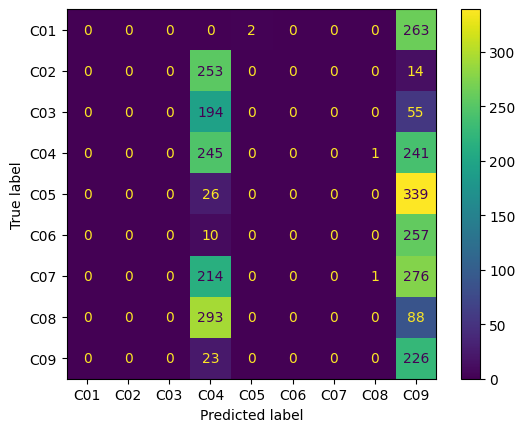

In [22]:
# Evaluate model
loss, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
y_proba = model.predict(X_val)
y_pred = y_proba.argmax(axis=-1)
print(f'Loss : {loss}')
print(f'Accuracy: {accuracy}')

labels = label_encoder.classes_
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [31]:
# Predict on test set
answer_list = []
for filename in (glob(test_dir + '/*.csv')):
    df = pd.read_csv(filename)
    df = preprocess(df)
    df = scaler.transform(df)
    samples = frame(df, frame_len, hop_len)
    y_pred_prob = model.predict(samples)
    y_pred = np.argmax(y_pred_prob, axis=1)
    class_names = label_encoder.inverse_transform(y_pred)
    value = (filename.split('/')[-1], class_names[0])
    answer_list.append(value)

# Create submission file
column_name = ['id','class']
submission_df = pd.DataFrame(answer_list, columns=column_name)
submission_df.to_csv('/kaggle/working/submission_lasthope.csv', index=None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [149]:
count_dict = {}
for _, value in answer_list:
    if value in count_dict:
        count_dict[value] += 1
    else:
        count_dict[value] = 1

# Print the count dictionary
print(count_dict)

{'C06': 98, 'C08': 120, 'C04': 117, 'C09': 74, 'C03': 91, 'C07': 186, 'C01': 82, 'C02': 80, 'C05': 126}


In [289]:
model.save('0.9603_BiLSTM.h5')

# Psudo-labeling

In [266]:
import torch

# create dict for collect confidence test data
to_move = {x: [] for x in range(9)}
threshold = 0.99   # How confidence of each answering

answers = {}

for filename in (glob(test_dir + '/*.csv')):
    key = filename
    df = pd.read_csv(filename)
    df = preprocess(df)
    df = scaler.transform(df)
    samples = frame(df, frame_len, hop_len)
    prob = model.predict(samples, verbose=False)

    # Get the predicted class idex by considering the most probability value
    predicted_class = np.argmax(prob, axis=1)[0]

    # If the model's confidence in the answer more than threshold, collect it
    if np.mean(prob, axis=0)[predicted_class] > threshold:
        to_move[predicted_class].append(key)
        print(f"Move {key} to class {predicted_class}")

Move /kaggle/input/har-competition-onsite/HAR/test/6b7fbfa5-06b9-4a93-97c8-6716eda96afa.csv to class 5
Move /kaggle/input/har-competition-onsite/HAR/test/911c86ae-0dec-47a6-a2f8-9b249dff59ea.csv to class 3
Move /kaggle/input/har-competition-onsite/HAR/test/ccbc40d8-d55a-40d4-84d2-21099bbe453c.csv to class 7
Move /kaggle/input/har-competition-onsite/HAR/test/c3fd8a15-ba4b-42d7-96a6-6a0cbb0f416f.csv to class 2
Move /kaggle/input/har-competition-onsite/HAR/test/18861196-4f0d-4273-8b48-83e07336a2e1.csv to class 2
Move /kaggle/input/har-competition-onsite/HAR/test/1cd3feef-7f38-4bdf-8b3e-44218e48e055.csv to class 6
Move /kaggle/input/har-competition-onsite/HAR/test/fe70b547-b88b-458a-bb31-dd44513bc7bf.csv to class 5
Move /kaggle/input/har-competition-onsite/HAR/test/479639bd-fdcd-43cc-a479-c356d65d44bb.csv to class 0
Move /kaggle/input/har-competition-onsite/HAR/test/49592390-020e-404d-9187-3e740f0afdba.csv to class 1
Move /kaggle/input/har-competition-onsite/HAR/test/979a246b-a596-458c-b73

In [267]:
count = 0
for i in range (9):
    count += len(to_move[i])
    
print(count)

765


In [282]:
labels = label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])

# Copy confidence data to training set
for pred_class in to_move:
    for item in to_move[pred_class]:
        file_name = item.split("/")[-1]
        shutil.copyfile(item, f"HAR/{labels[pred_class]}/{file_name}")

In [284]:
len(os.listdir('/kaggle/working/HAR/C01'))

79